In [20]:
using DiffEqNoiseProcess, SciMLBase, PyPlot
seed = 1337

Z1 = WienerProcess(0.0, im * 0.0, im * 0.0, reseed=false, reset=false)
prob1 = NoiseProblem(Z1, (0.0, 10.0), seed=seed, save_noise=true)
sol1 = solve(prob1; dt = 0.1)

prob2 = NoiseProblem(Z1, (0.0, 10.0), seed=seed, save_noise=true)
sol2 = solve(prob1; dt = 0.2);

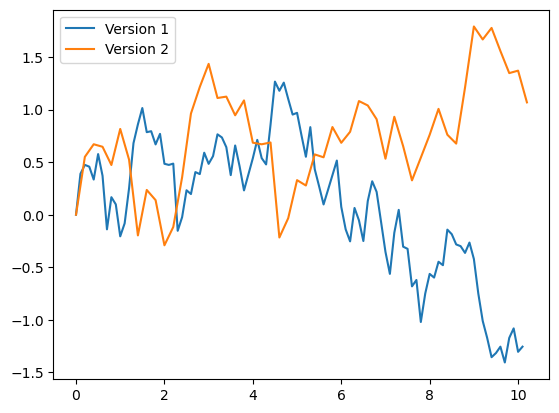

In [21]:
plot(sol1.t, real.(sol1.u), label="Version 1")
plot(sol2.t, real.(sol2.u), label="Version 2")
legend()
PyPlot.display_figs()

In [1]:
using QuantumOptics, DiffEqNoiseProcess, PyPlot, DifferentialEquations, SparseArrays

Nspin = 10
κ = 2π*0.15 # MHz
Δc = 2π*20 # MHz
ωz = 2π*0.01 # MHz
seed = 1729
tmax = 50.0 # μs
recordtimes = 50
tspan = range(0.0, tmax, recordtimes)

sb = SpinBasis(Nspin // 2)
Sx = sigmax(sb) / 2
Sy = sigmay(sb) / 2
Sz = sigmaz(sb) / 2
idOp = identityoperator(sb)
ψ0 = spindown(sb)
ψ0 = normalize!(ψ0)

gc = sqrt(ωz*(Δc^2 + κ^2)/abs(Nspin*Δc))
grel(t) = 1.0 #0.9*smoothstep(t/200.)

αplus = Δc/(-Δc + ωz - im*κ) + Δc/(-Δc - ωz - im*κ)
αminus = Δc/(-Δc + ωz - im*κ) - Δc/(-Δc - ωz - im*κ)

C(t) = (grel(t)*gc)*sqrt(κ)/(2*Δc)*(αplus*Sx+im*αminus*Sy)
H0(t) = ωz*Sz - (grel(t)*gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy)
H_nl(ψ,t) = im * expect(dagger(C(t)), normalize(ψ)) * C(t) - 0.5im * dagger(C(t)) * C(t) - 0.5im * expect(dagger(C(t)), normalize(ψ)) * expect(C(t), normalize(ψ)) * idOp
fdet_homodyne(t, ψ) = H0(t) + H_nl(ψ, t)
fst_homodyne(t, ψ) = [C(t) - expect(C(t), normalize(ψ)) * idOp]

Z1 = WienerProcess(0.0, im * 0.0, im * 0.0, reseed=false)
tout, psi_t_EM = stochastic.schroedinger_dynamic(tspan, ψ0, fdet_homodyne, fst_homodyne; normalize_state=true, noise=Z1, seed=seed, alg=LambaEM(), dt=0.001, reltol=10^-4, abstol=10^-4, maxiters=10^8);

tout, psi_t_SOSRI2 = stochastic.schroedinger_dynamic(tspan, ψ0, fdet_homodyne, fst_homodyne; normalize_state=true, noise=Z1, seed=seed, alg=SOSRI2(), dt=0.001, reltol=10^-4, abstol=10^-4, maxiters=10^8);

In [2]:
diff = psi_t_SOSRI2[end] - psi_t_EM[end]
print(sqrt(dagger(diff)*diff))

0.08833419130815971 - 1.5484557167990323e-19im

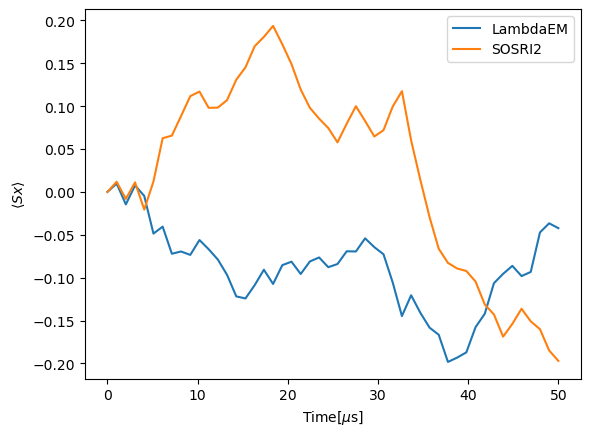

/Users/henryhunt/.julia/conda/3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [3]:
plot(tout, expect(Sx, psi_t_EM), label="LambdaEM")
plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()